<a href="https://colab.research.google.com/github/TimurMMD/AI_LSBF-UEL_project/blob/main/Random_Forest_Image_Classification_charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

In [3]:
# Define the transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Load the dataset
data_dir = '/content/drive/My Drive/AI&MV/seg_test/seg_test'
dataset = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# Load a pretrained ResNet model
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer
resnet.eval()

# Extract features
features = []
labels = []

with torch.no_grad():
    for images, label in data_loader:
        outputs = resnet(images)
        outputs = outputs.view(outputs.size(0), -1)
        features.append(outputs.cpu().numpy())
        labels.append(label.cpu().numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
# Function to simulate epochs
def simulate_epochs(X, y, n_estimators, n_splits):
    train_accuracies = []
    test_accuracies = []

    for i in range(1, n_splits + 1):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Use a subset of training data
        subset_size = int(len(X_train) * i / n_splits)
        X_train_subset = X_train[:subset_size]
        y_train_subset = y_train[:subset_size]

        # Train the Random Forest classifier
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf.fit(X_train_subset, y_train_subset)

        # Predict and evaluate on training data
        y_train_pred = rf.predict(X_train_subset)
        train_accuracy = accuracy_score(y_train_subset, y_train_pred)
        train_accuracies.append(train_accuracy)

        # Predict and evaluate on testing data
        y_test_pred = rf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies

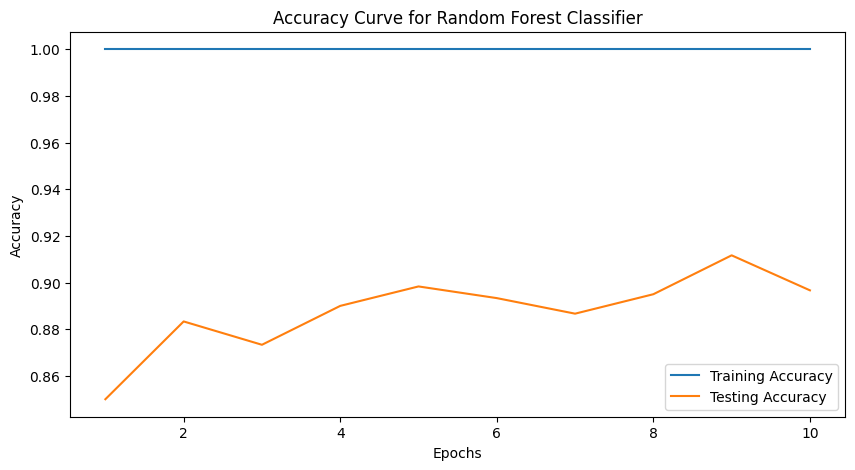

In [7]:
# Simulate epochs
n_splits = 10  # Number of splits/epochs
n_estimators = 100
train_accuracies, test_accuracies = simulate_epochs(features, labels, n_estimators, n_splits)

# Plotting the accuracy curves
epochs = np.arange(1, n_splits + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Random Forest Classifier')
plt.legend()
plt.show()

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy:.4f}')

Random Forest Accuracy: 0.8967


In [9]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)
print("----------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=dataset.classes))

Confusion Matrix:
[[96  0  0  0  0  8]
 [ 0 96  0  0  1  0]
 [ 1  2 83 15  4  2]
 [ 0  0 19 83  2  0]
 [ 0  1  1  1 89  1]
 [ 4  0  0  0  0 91]]
----------------------------
Classification Report:
              precision    recall  f1-score   support

   buildings       0.95      0.92      0.94       104
      forest       0.97      0.99      0.98        97
     glacier       0.81      0.78      0.79       107
    mountain       0.84      0.80      0.82       104
         sea       0.93      0.96      0.94        93
      street       0.89      0.96      0.92        95

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



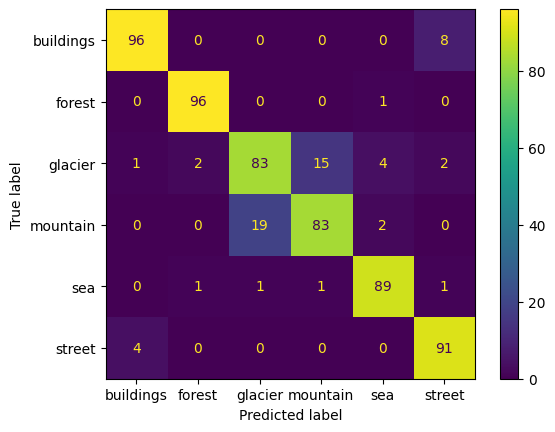

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=dataset.classes)
disp.plot()
plt.show()